# Выбор локации для скважины

## Описание проекта

Вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Условия задачи

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
Бюджет на разработку скважин в регионе — 10 млрд рублей.  
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  

### Описание данных

id — уникальный идентификатор скважины;  
f0, f1, f2 — три признака точек;  
product — объём запасов в скважине (тыс. баррелей).

## Импорт библиотек

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.model_selection import(
    train_test_split,
    GridSearchCV,
)

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import(
    StandardScaler, MinMaxScaler, RobustScaler
)

from sklearn.compose import ColumnTransformer
from sklearn.metrics import  make_scorer

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

import os

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Константы

In [15]:
RANDOM_STATE = 42
state = np.random.RandomState(12345)

## Используемые функции

### Получение общей информации о датасете

In [18]:
def info(df):
    display(df.head())
    print('____')
    print(df.info())
    print('____')
    print(pd.DataFrame(df.isna().sum(), columns=['Количество пропусков']))
    print('____')
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print('____')
    print(f'Названия столбцов: {df.columns}')

### Гистограмма и диаграмма размаха для количественных признаков

In [20]:
def plot(df):
    num_col = df.select_dtypes(include='number').columns
    for column in num_col:
        plt.figure(figsize=(14, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(x=df[column], color = 'darkcyan', bins='auto', kde=True)
        plt.title(column)      
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[column], color = 'darkcyan')
        plt.title(column)
        plt.show()

### Матрица корреляций

In [22]:
def corr_matrix(df, name):
    plt.figure(figsize=(10, 5))
    sns.heatmap(df.corr(method='spearman'), annot=True, cmap='cividis', annot_kws={"size": 12},\
    mask=np.triu(df.corr(method='spearman')))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f'Матрица корреляций Спирмена ({name})', fontsize=20);

### Разбивка на тренировочную и валидационную выборки (в соотношении 75:25)

In [24]:
def df_split(df, target):
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=RANDOM_STATE, test_size = 0.25)
    print(f'Размер тренировочных выборок: {X_train.shape}, {y_train.shape}.\
    Размер валидационных выборок {X_valid.shape}, {y_valid.shape}')
    return X_train, X_valid, y_train, y_valid

### Расчет RMSE

In [26]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)
rmse_scorer = make_scorer(rmse, greater_is_better=False) 

### Сохранение предсказанных и рельных результатов, подсчет среднего объема нефти

In [28]:
def predict(best_estimator, X_valid, y_valid, region):
    print(region)
    prediction = best_estimator.predict(X_valid)
    print(f'Метрика RMSE на валидационной выборке: {rmse(y_valid, prediction).round(2)}')
    result = pd.DataFrame({
    'предсказанные_значения': prediction,
    'реальные_значения': y_valid
    })
    display(result.head())
    print(f'Среднее значение предсказанных объемов нефти составило '
      f'{result["предсказанные_значения"].mean().round(3)} тыс. баррелей')
    return (result)

## Загрузка и подготовка данных

In [30]:
pth1 = 'C:/Users/knadi/Desktop/practicum/проекты/машинное обучение в бизнесе нефть/geo_data_0.csv'
pth2 = '/datasets/geo_data_0.csv'

if os.path.exists(pth1):
    region_0 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    region_0 = pd.read_csv(pth2)
else:
    print('Something is wrong')
info(region_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


____
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
____
         Количество пропусков
id                          0
f0                          0
f1                          0
f2                          0
product                     0
____
Количество дубликатов: 0
____
Названия столбцов: Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')


In [31]:
pth3 = 'C:/Users/knadi/Desktop/practicum/проекты/машинное обучение в бизнесе нефть/geo_data_1.csv'
pth4 = '/datasets/geo_data_1.csv'

if os.path.exists(pth3):
    region_1 = pd.read_csv(pth3)
elif os.path.exists(pth4):
    region_1 = pd.read_csv(pth4)
else:
    print('Something is wrong')
info(region_1)


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


____
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
____
         Количество пропусков
id                          0
f0                          0
f1                          0
f2                          0
product                     0
____
Количество дубликатов: 0
____
Названия столбцов: Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')


In [32]:
pth5 = 'C:/Users/knadi/Desktop/practicum/проекты/машинное обучение в бизнесе нефть/geo_data_2.csv'
pth6 = '/datasets/geo_data_2.csv'

if os.path.exists(pth5):
    region_2 = pd.read_csv(pth5)
elif os.path.exists(pth6):
    region_2 = pd.read_csv(pth6)
else:
    print('Something is wrong')
info(region_2)


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


____
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
____
         Количество пропусков
id                          0
f0                          0
f1                          0
f2                          0
product                     0
____
Количество дубликатов: 0
____
Названия столбцов: Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')


Столбец ID можно сделать индексом и выполнить повторный поиск дубликатов.

In [34]:
region_0.set_index('id', inplace=True)
region_0.duplicated().sum()

0

In [35]:
region_1.set_index('id', inplace=True)
region_1.duplicated().sum()

0

In [36]:
region_2.set_index('id', inplace=True)
region_2.duplicated().sum()

0

**Загружены данные, содержащие информацию о характеристиках скважин в трех регионах, все представленные признаки являются количественными. Тип данных соответствует соответствует значениям в столбцах, пропуски и дубликаты отсутствуют.**

## Исследовательский анализ данных

In [39]:
region_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


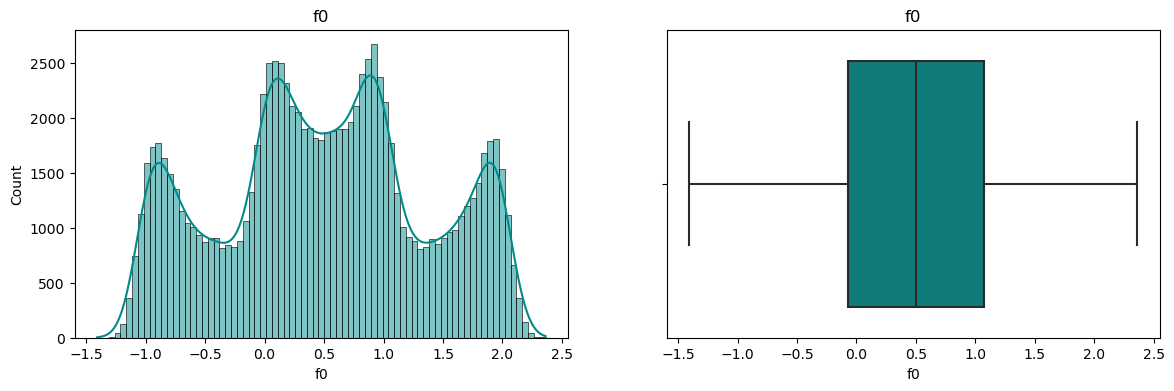

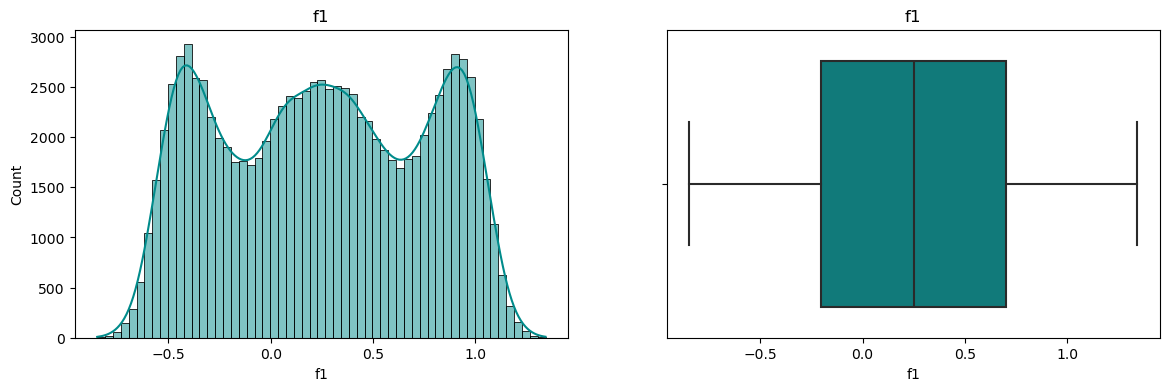

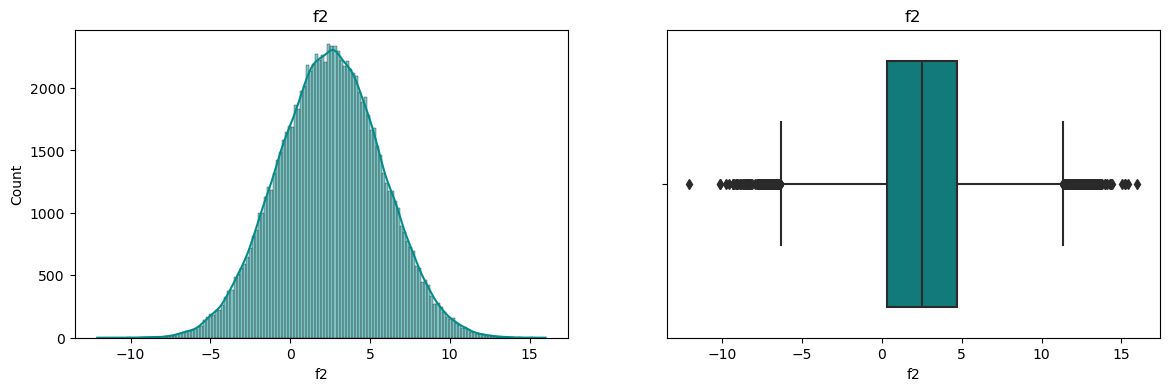

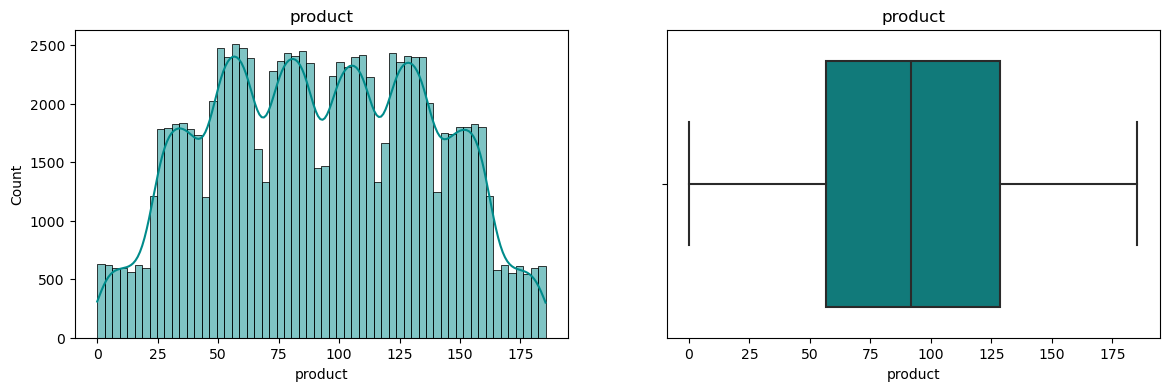

In [40]:
plot(region_0)

In [41]:
region_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


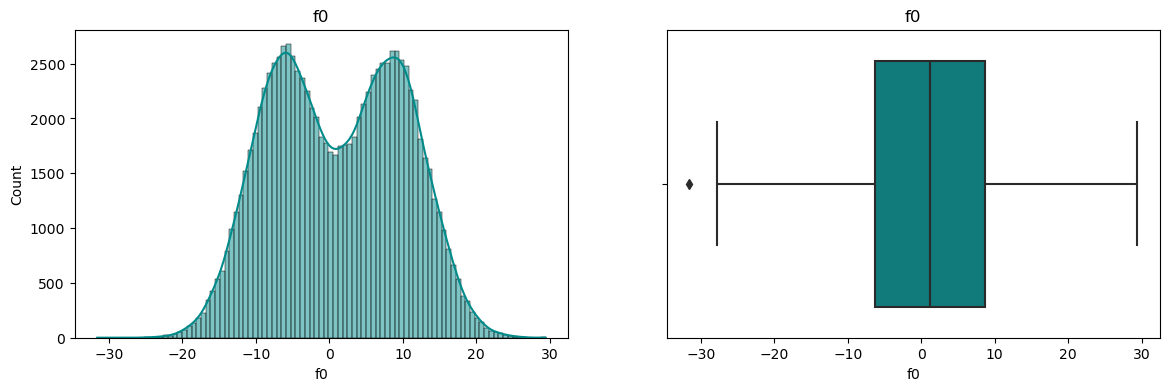

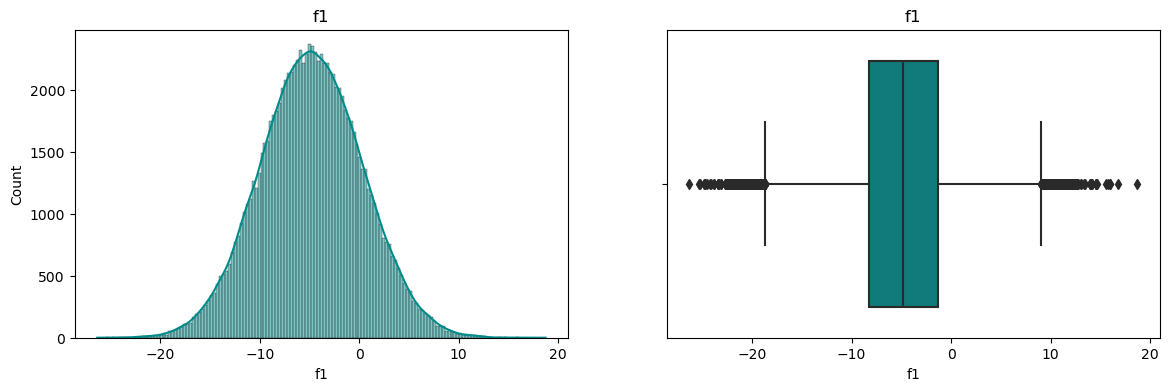

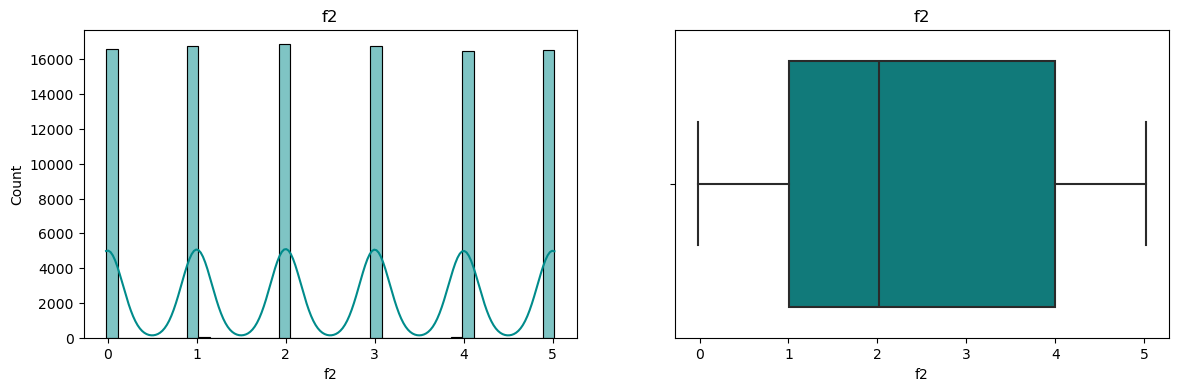

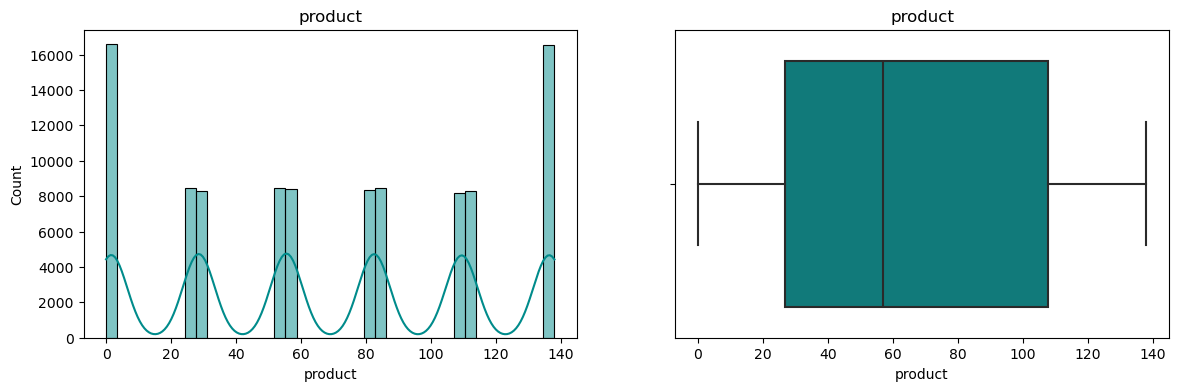

In [42]:
plot(region_1)

In [43]:
region_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


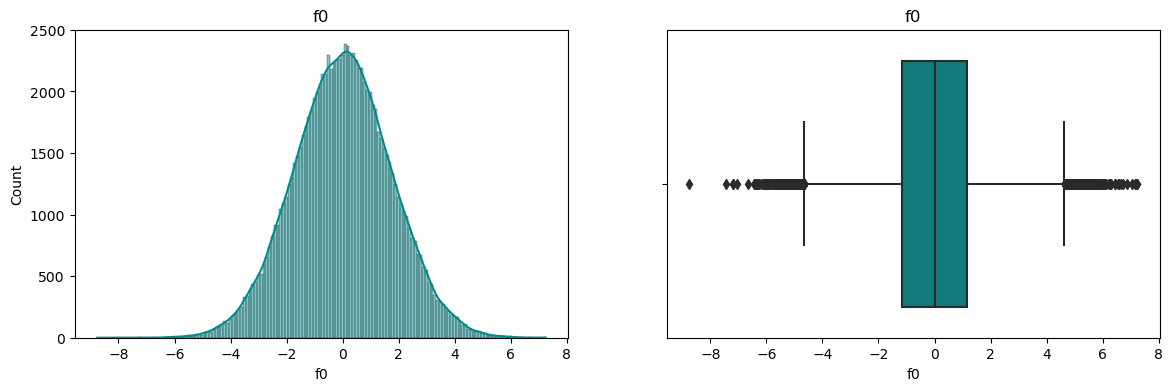

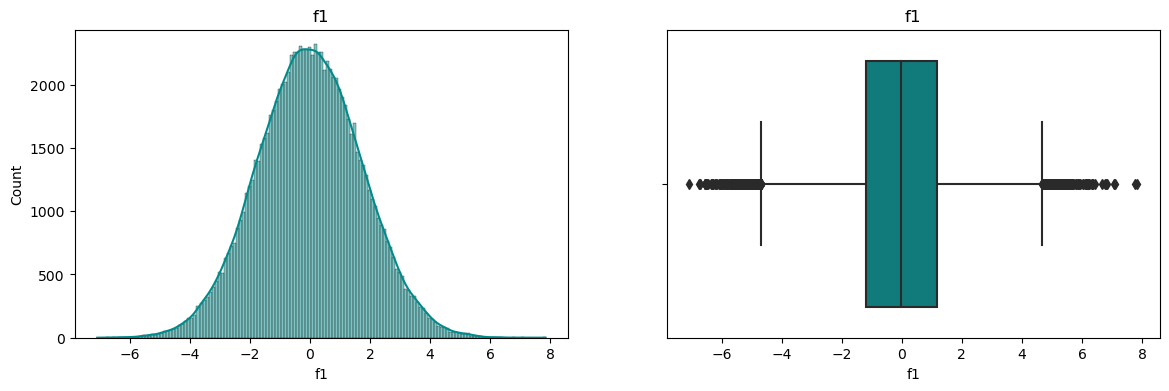

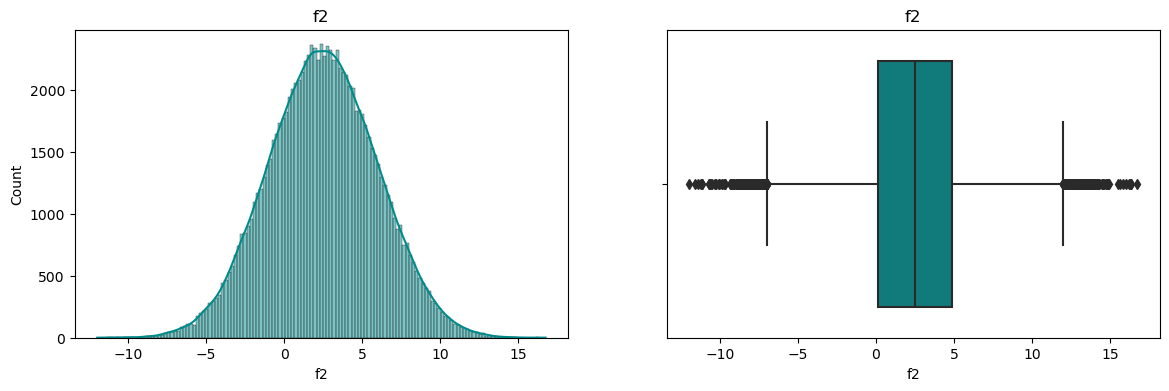

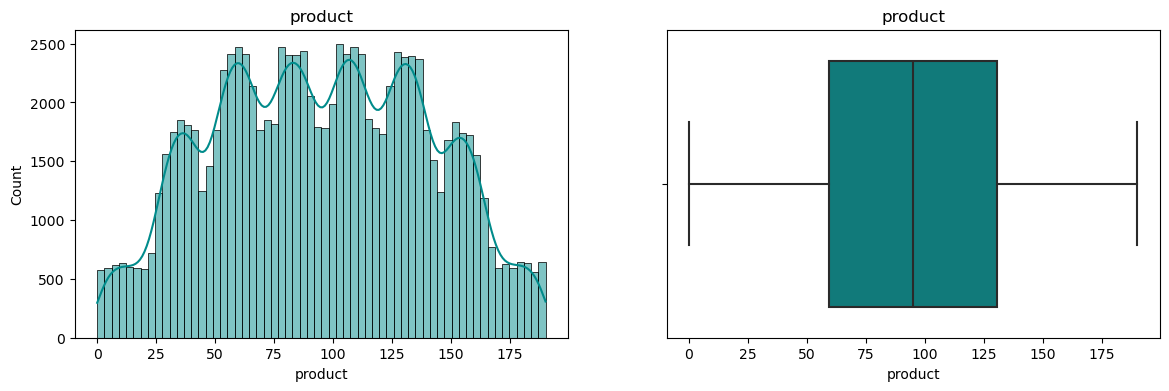

In [44]:
plot(region_2)

**Характер распределения признаков и диапазон значений различен в каждом из исследуемых регионов, т.е. каждый регион уникален, в связи с чем модели для предсказания объемов нефти будут обучаться на данных каждого региона по отдельности.  
Максимальное значение средних запасов нефти наблюдается для региона №2.  
Для некоторых исследуемых скважин характерно остсутсвие запасов нефти (product = 0).   
В данных имеются выбросы, однако без понимания значения признаков считать их аномалиями и удалять не следует.**

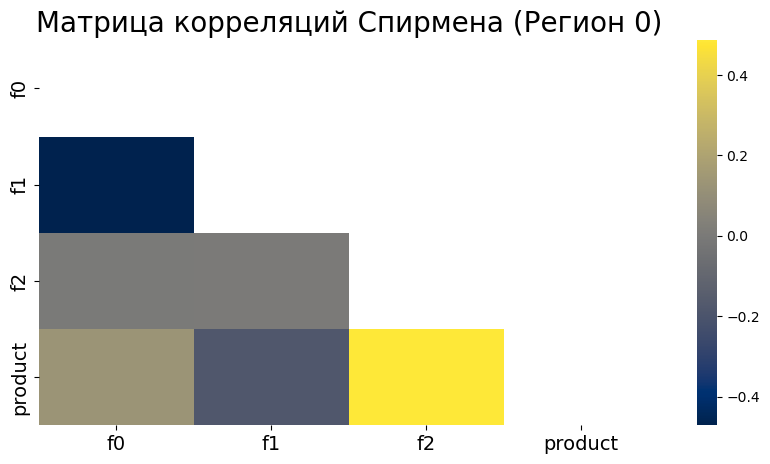

In [46]:
corr_matrix(region_0, 'Регион 0')

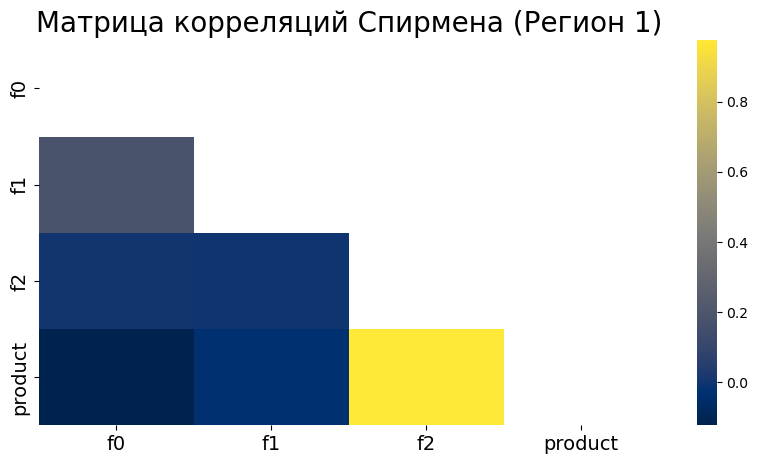

In [47]:
corr_matrix(region_1, 'Регион 1')

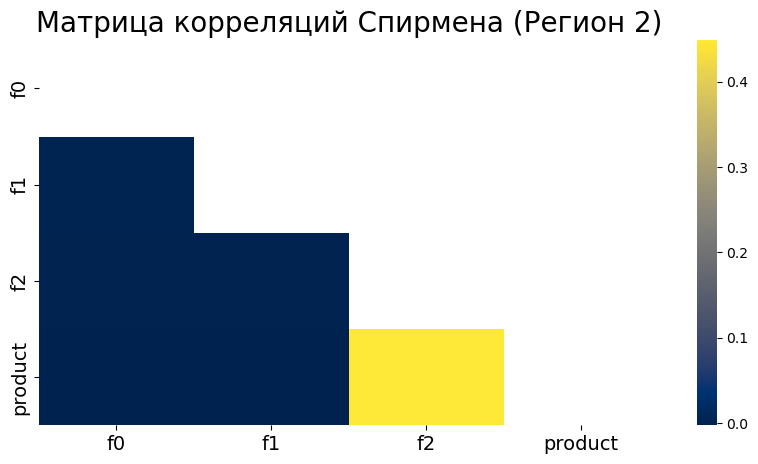

In [48]:
corr_matrix(region_2, 'Регион 2')

**Мультиколлинеарности между входными признаками не наблюдается. Самым значимым признаком, влияющим на объем запасов нефти, является признак f2.**

## Обучение и проверка модели

### Регион 0

In [53]:
X_train_0, X_valid_0, y_train_0, y_valid_0 = df_split(region_0, 'product')

Размер тренировочных выборок: (75000, 3), (75000,).    Размер валидационных выборок (25000, 3), (25000,)


In [54]:
pipe_final = Pipeline([
    ('scaler', 'passthrough'),  
    ('model', LinearRegression())  
])


param = [
    {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    }
]

gscv_0 = GridSearchCV(
    pipe_final, 
    param_grid=param, 
    scoring=rmse_scorer, 
    n_jobs=-1
)
gscv_0.fit(X_train_0, y_train_0)

print('Оптимальные параметры модели', gscv_0.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -gscv_0.best_score_.round(2))

Оптимальные параметры модели Pipeline(steps=[('scaler', 'passthrough'), ('model', LinearRegression())])
Метрика лучшей модели на кросс-валидации: 37.67


In [55]:
result_0 = predict(gscv_0.best_estimator_, X_valid_0, y_valid_0, 'Регион 0')

Регион 0
Метрика RMSE на валидационной выборке: 37.76


,предсказанные_значения,реальные_значения
id,,
7C6bA,101.901017,122.073350
dVxsn,78.217774,48.738540
1Gm3l,115.266901,131.338088
Nzg1t,105.618618,88.327757
Z7b4F,97.980185,36.959266


Среднее значение предсказанных объемов нефти составило 92.399 тыс. баррелей


### Регион 1

In [57]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = df_split(region_1, 'product')

Размер тренировочных выборок: (75000, 3), (75000,).    Размер валидационных выборок (25000, 3), (25000,)


In [58]:
gscv_1 = GridSearchCV(
    pipe_final, 
    param_grid=param, 
    scoring=rmse_scorer, 
    n_jobs=-1
)
gscv_1.fit(X_train_1, y_train_1)

print('Оптимальные параметры модели', gscv_1.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -gscv_1.best_score_.round(2))

Оптимальные параметры модели Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LinearRegression())])
Метрика лучшей модели на кросс-валидации: 0.89


In [59]:
result_1 = predict(gscv_1.best_estimator_, X_valid_1, y_valid_1, 'Регион 1')

Регион 1
Метрика RMSE на валидационной выборке: 0.89


,предсказанные_значения,реальные_значения
id,,
fYVDK,0.844738,0.000000
3SQcq,52.921612,53.906522
hQ1gJ,135.110385,134.766305
Y4vux,109.494863,107.813044
H1NUw,-0.047292,0.000000


Среднее значение предсказанных объемов нефти составило 68.713 тыс. баррелей


### Регион 2

In [61]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = df_split(region_2, 'product')

Размер тренировочных выборок: (75000, 3), (75000,).    Размер валидационных выборок (25000, 3), (25000,)


In [62]:
gscv_2 = GridSearchCV(
    pipe_final, 
    param_grid=param, 
    scoring=rmse_scorer, 
    n_jobs=-1
)
gscv_2.fit(X_train_2, y_train_2)

print('Оптимальные параметры модели', gscv_2.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -gscv_2.best_score_.round(2))

Оптимальные параметры модели Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])
Метрика лучшей модели на кросс-валидации: 40.03


In [63]:
result_2 = predict(gscv_2.best_estimator_, X_valid_2, y_valid_2, 'Регион 2')

Регион 2
Метрика RMSE на валидационной выборке: 40.15


,предсказанные_значения,реальные_значения
id,,
sPjbT,98.301916,117.441301
1u4uo,101.592461,47.841249
kZ6HO,52.449099,45.883483
gCZGK,109.922127,139.014608
rqJHx,72.411847,84.004276


Среднее значение предсказанных объемов нефти составило 94.771 тыс. баррелей


**Разработы линейные модели, прогнозирующие объемы запасов нефти в скважинах, на основе входных признаков f0, f1 и f2. Рассчитаны средние значения предсказанных объемов нефти. Получены следующие результаты:**
- Регион 0.
Среднее значение предсказанных объемов нефти составило 92.399 тыс. баррелей, RMSE = 37.76.
- Регион 1.
Среднее значение предсказанных объемов нефти составило 68.713 тыс. баррелей, RMSE = 0.89.
- Регион 2.
Среднее значение предсказанных объемов нефти составило 94.771 тыс. баррелей, RMSE = 40.15.

**Таким образом, максимальные запасы нефти спрогнозированы для региона 2.  
Однако наиболее точные прогнозы получены для региона 1, где средняя ошибка прогнозов составила всего 0.89 тыс. баррелей, что, вероятно, связано с очень высокой корреляцией объемов нефти с входным признаком f2 в данном регионе.**

**Данные с предсказаниями и реальными значениями объемов нефти для каждого из регионов сохранены в result_0, result_1 и result_2.**

## Подготовка к расчёту прибыли

In [67]:
BUDGET = 10*(10**9)          # бюджет на разработку
COST_1000_BARREL = 450000    # стоимость 1 тыс. баррелей
MAX_WELL = 500               # количество исследуемых скважин
TARGET_WELL = 200            # количество скважин для разработки

In [68]:
min_volume = BUDGET/COST_1000_BARREL
min_volume

22222.222222222223

In [69]:
average_volume_per_well = min_volume/TARGET_WELL
average_volume_per_well

111.11111111111111

**Общий объем добытой нефти для безубыточной разработки должен составить не менее 22222.222 тыс. баррелей.   
В среднем из каждой из 200 скважин должно быть получено не менее 111.111 тыс. баррелей нефти.  
Средние спрогнозированные значения объемов нефти в каждом из регионов меньше 111.111 тыс. баррелей, однако при расчетах использовались данные по всем скважинам, а не по скважинам с максимальными запасами нефти.**

## Расчёт прибыли и рисков 

In [74]:
def income(df):
    top_wells = df.sort_values(by='предсказанные_значения', ascending=False)[:TARGET_WELL] 
    sum_oil = sum(top_wells['реальные_значения']) 
    return (sum_oil*COST_1000_BARREL-BUDGET)

Написана функция для расчета прибыли: отбирается 200 скважин с максимальными предсказанными запасами нефти, для выбранных скважин проводится расчет прибыли с учетом реальных запасов нефти. Отбор случайных 500 скважин из всего набора данных будет произведен методом бутстрепа.

In [76]:
def risk(df, region):

    values = []

    for i in range(1000):
        sample_wells = df.sample(n=MAX_WELL, replace=True, random_state=state)
        values.append(income(sample_wells))

    values = pd.Series(values)
    
    lower = (values.quantile(0.025)/1000).round(1)
    upper = (values.quantile(0.975)/1000).round(1)

    mean = (values.mean()/1000).round(1)
    
    negative_profit = (values < 0).mean()*100
    
    print(f'Средняя прибыль ({region}): {mean} тыс. руб')
    print(f'95%-й доверительный интервал: ({lower} - {upper}) тыс. руб')
    print(f'Вероятность убытка: {negative_profit} %')

Написана функция выполняющая расчет средней прибыли и рисков методом бутстрепа: из всех скважин в регионе случайным образом отбирается 500, по которым проводится расчет прибыли с помощью ранее написанной функции, данная итерация повторяется 1000 раз, таким образом высчитывается средняя прибыль при разработке в конкретном регионе, определяются доверительные интервалы, а также оцениваются риски, как отношение количества результатов с отрицательной прибылью к общему количеству результатов (1000).

In [78]:
risk(result_0, 'Регион 0')

Средняя прибыль (Регион 0): 406278.8 тыс. руб
95%-й доверительный интервал: (-117742.1 - 911737.1) тыс. руб
Вероятность убытка: 6.7 %


In [79]:
risk(result_1, 'Регион 1')

Средняя прибыль (Регион 1): 441504.3 тыс. руб
95%-й доверительный интервал: (35728.5 - 828006.6) тыс. руб
Вероятность убытка: 1.6 %


In [80]:
risk(result_2, 'Регион 2')

Средняя прибыль (Регион 2): 385213.2 тыс. руб
95%-й доверительный интервал: (-164785.2 - 888206.2) тыс. руб
Вероятность убытка: 7.8 %


**Методом бутстрепа был смоделирован отбор 500 скважин в каждом из регионов и оценена средняя прибыль и вероятность убытков. Полученные результаты для региона 0 и региона 2 демонстрируют высокую веротность убытков в данных регионах (более 2,5 %).   Наиболее перспективным для разработок является регион 1, где прогнозируется самая высокая прибыль и минимальный риск убытков.**

## Общий вывод

- **Были получены данные, содержащие информацию о характеристиках скважин в трех регионах (регион 0, регион 1, регион 2).**
- **Для каждого из регионов была построена линейная модель, предсказывающая объемы запасов нефти. Наиболее точные прогнозы получены для региона 1.**
- **Методом бутстрепа смоделирован отбор 500 случайных скважин в каждом из регионов, из которых выбиралось 200 скважин с максимальными предсказанными объемами запасов нефти. Была вычислена средняя прибыль, доверительные интервалы и вероятность убытков.**
- **Показано, что наиболее преспективным для разработок является регион 1, средняя спрогнозированная прибыль, в котором составила 441504.3 тыс. руб, а риск получения убытков составил 1.6 % (риски для других регионов значительно выше).**